In [ ]:
! pip install qiskit

KMEANSアルゴリズムの量子コンピュータ実装<br>
* 振幅符号化を使った実装サンプルコード


In [5]:
# qiskit import
from qiskit import *
from qiskit.tools.visualization import *
from qiskit.quantum_info import state_fidelity, process_fidelity

# 必要なライブラリをimportする
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import preprocessing
import seaborn as sns
import copy
import math
import os


amp_def: データを振幅値に変換

In [6]:
def amp_def(X):
  X_size,X_features = X.shape
  # 出力用配列の初期化
  amp_X = np.zeros((X_size, X_features),dtype=np.float64)
  # 入力配列を振幅値に変換する
  for i in range(X_size):
    if np.sum(X[i,:]) == 0:
      X[i,:] += 1
    amp_X[i,:] = X[i,:] / math.sqrt(np.sum(X[i,:] ** 2)) 
  return amp_X

符号化した量子ビットのstateの一致度で判定するQMEANS<br>
多次元データセット対応バージョン：4次元数

In [16]:
# Quantum means処理の定義  ：Fidelityで判別する
def qmeans_amp_F(k,X,max_iter=1000,v=0.05):
  X_size,n_features = X.shape
  # 初期値を平均と分散から決定する
  # mean = np.mean(X, axis = 0)
  # std = np.std(X, axis = 0)
  # centroids  = np.random.randn(k,n_features)*std + mean
  for i in range(k):
      if i > 0:
          centroids = np.append(centroids,X[np.random.choice(X_size,1,replace=False),:],axis=0)
      else:
          centroids = X[np.random.choice(X_size,1,replace=False),:]
  # 入力配列を振幅値へ変換
  X_amp = amp_def(X)
  centroids_amp = amp_def(centroids)
  # 中心点比較用の配列準備
  new_centroids = np.zeros((k, n_features))
  # クラスターラベル配列準備
  label_c = np.zeros(X_size)
  # ループ上限回数まで繰り返し
  for epoch in range(max_iter):
      #  print("epoch=",epoch)     # for debug
      for e in range(X_size):
        # Input data の符号化とstate取得
        q0 = QuantumRegister(2)        
        qc0 = QuantumCircuit(q0)
        initial_state_q0 = X_amp[e,:]
        qc0.initialize(initial_state_q0, [q0[0],q0[1]])
        backend = BasicAer.get_backend('statevector_simulator')
        job0 = backend.run(transpile(qc0, backend))
        qc_state0 = job0.result().get_statevector(qc0)
        # print(qc_state0) 
        f_dim = np.zeros(k)
        # cluster=0 との比較
        initial_state_q1 = centroids_amp[0,:]
        q1 = QuantumRegister(2)
        qc1 = QuantumCircuit(q1)
        qc1.initialize(initial_state_q1,[q1[0],q1[1]])
        job1 = backend.run(transpile(qc1, backend))
        qc_state1 = job1.result().get_statevector(qc1)    
        # print(qc_state1)
        f_dim[0] = state_fidelity(qc_state0, qc_state1)
        # cluster=1 との比較
        initial_state_q2 = centroids_amp[1,:]
        q2 = QuantumRegister(2)
        qc2 = QuantumCircuit(q2)
        qc2.initialize(initial_state_q2,[q2[0],q2[1]])
        job2 = backend.run(transpile(qc2, backend))
        qc_state2 = job2.result().get_statevector(qc2)    
        # print(qc_state2)
        f_dim[1] = state_fidelity(qc_state0, qc_state2)
        # cluster=2 との比較
        initial_state_q3 = centroids_amp[2,:]
        q3 = QuantumRegister(2)
        qc3 = QuantumCircuit(q3)
        qc3.initialize(initial_state_q3,[q3[0],q3[1]])
        job3 = backend.run(transpile(qc3, backend))
        qc_state3 = job3.result().get_statevector(qc3)    
        # print(qc_state3)
        f_dim[2] = state_fidelity(qc_state0, qc_state3)
        # fedelity state の最大値インデックスをlabelにする
        label_c[e] = np.argmax(f_dim)
        df_s = pd.DataFrame(f_dim,columns=['fedelity'])
        df_s.to_csv('../content/data/swaptest.csv',mode='a')

      # 新しい中心点を算出
      for j in range(k):
           new_centroids[j] = X[label_c==j,:].mean(axis=0)
      # print("centroids=",centroids)
      # print("new centroids=",new_centroids)
      # 欠損値は平均に置き換え
      new_centroids = np.nan_to_num(new_centroids, np.nanmean(X))
      error = np.linalg.norm(new_centroids - centroids)
      print("centroids deff =", error, file=myfile)
      # 中心点の変化が変数vより小さければ終了
      if float(error) < float(v) :
           print("break")
           break
      df_c = pd.DataFrame(centroids,columns=['c1','c2','c3','c4'])
      df_c.to_csv('../content/data/centroids_hist.csv',mode='a')
      centroids =  copy.copy(new_centroids)
      centroids_amp = amp_def(centroids)
      print("new_centroids=",centroids_amp)
  return label_c,centroids_amp

クラスタリングデータの準備

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'label'],
      dtype='object')
   sepal length (cm)  sepal width (cm)  ...  petal width (cm)  label
0                5.1               3.5  ...               0.2      0
1                4.9               3.0  ...               0.2      0
2                4.7               3.2  ...               0.2      0
3                4.6               3.1  ...               0.2      0
4                5.0               3.6  ...               0.2      0
5                5.4               3.9  ...               0.4      0
6                4.6               3.4  ...               0.3      0
7                5.0               3.4  ...               0.2      0
8                4.4               2.9  ...               0.2      0
9                4.9               3.1  ...               0.1      0

[10 rows x 5 columns]
       sepal length (cm)  sepal width (cm)  ...  petal width (cm)       label
count       

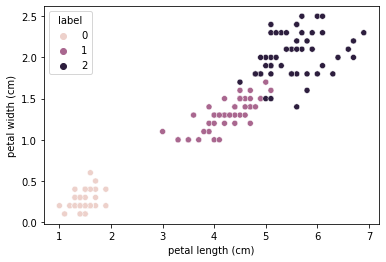

In [19]:
# irisデータセットを読み込み
iris = datasets.load_iris()       # irisを読み込む関数
df = pd.DataFrame(        
    iris.data,                    # データフレームの要素
    columns = iris.feature_names  # 各列の名前に特徴名を使う
)
df["label"] = iris.target         # わかりやすくするためにlabel列を追加
 
print(df.columns)                 #  カラムの表示
print(df.head(10))                #　最初の10行表示　　最後のデータはtail
print(df.describe())              # データフレーム要約統計量

sns.scatterplot(x='petal length (cm)', y='petal width (cm)',hue='label', data=df)  #　データ可視化

irisデータセットの4項目をそのままインプットにする<br>
振幅値へ変換する

In [ ]:
# numpy arrayに変換  labelを除外
np_iris = df[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)','petal width (cm)']].to_numpy(copy=True)
# 振幅値に変換する
iris_amp = amp_def(np_iris)
# print(iris_amp)

In [17]:
# ログファイルの前処理
import os
os.makedirs('../content/data', exist_ok=True)
if os.path.exists('../content/data/swaptest.csv') == True:
  os.remove('../content/data/swaptest.csv')
if os.path.exists('../content/data/centroids_hist.csv') == True:
  os.remove('../content/data/centroids_hist.csv')
if os.path.exists('../content/data/nd_iris_scale.txt') == True:
  os.remove('../content/data/nd_iris_scale.txt')
np.savetxt('../content/data/nd_iris_scale.txt', iris_amp)

# ログファイルのオープン
myfile = open("../content/data/sysout.txt", "w")

# qmeans実行
label_c,centroids_amp=qmeans_amp_F(3,iris_amp,max_iter=2,v=0.05)

# ログファイルのクローズ
myfile.close()

new_centroids= [[0.8020181  0.54786919 0.23466576 0.03922104]
 [0.7369672  0.32012073 0.56718973 0.18082554]
 [0.71309809 0.35862771 0.56414589 0.21122666]]
break


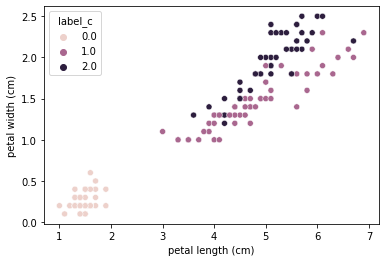

In [20]:
# 多次元クラスタリング結果表示
# クラスタリング結果の可視化 : petal length , petal width 
df_cluster = pd.DataFrame(label_c,columns=['label_c'])
df_plot = pd.concat([df,df_cluster],axis=1)
sns.scatterplot(x='petal length (cm)', y='petal width (cm)',hue='label_c', data=df_plot)  #　データ可視化